In [1]:
import warnings
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import json
import operator
import copy, random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from itertools import cycle
from math import pi


warnings.filterwarnings('ignore')

# Step 0: Provide the path to the experiments

In [2]:
your_path = '/home/rachel-baker/Desktop'
path = "{}/valentine-paper-results/data/".format(your_path)

# Step 1: Rename files 
> **Note**: Only run this if you have new results

In [3]:
files = []
for folder in os.listdir(path):
    if folder.startswith('.'):
        continue
    for file in os.listdir(path+folder):
        filename = folder+'/'+file
        if filename.endswith(".json"):
            files.append('.'.join(filename.split('.')[:-1]))

for f in files:
    g = f.replace('EmbDI_with_cid_all_with_rid_first_flatten_all_', "EmbDI{'with_cid': 'all', 'with_rid': 'first', 'flatten': 'all'}")
    g = g.replace('evCupid','ev__Cupid')
    g = g.replace('__CorrelationClustering','__DistributionBased')
    g = g.replace('evSimilarityFlooding','ev__SimilarityFlooding')
    g = g.replace('evJaccardLevenMatcher','ev__JaccardLevenMatcher')
    g = g.replace('_threshold_0_0_process_num_4_', "00{'process_num': 4}")
    g = g.replace('_threshold_0_25_process_num_4_', "025{'process_num': 4}")
    g = g.replace('_threshold_0_5_process_num_4_', "05{'process_num': 4}")
    if 'COMA_OPT_INST' in g:
        g = g.replace('__Coma','__COMA-SI')
    else:
        g = g.replace('__Coma','__COMA-S')


#     print(g)
    os.rename(path+f+'.json',path+g+'.json')

# Step 2: Read files


Parse the result files and present a table with the precision and recall metrics for all the experiments

for every algorithm create a plot for each metric

Code below read the output of the framework and creates a dict of metrics.

In [4]:
total_metrics = {}
run_times = {}

def show_the_output(path: str):
    
    with open('%s'%(path),'r') as input:
        split_path = path.split('/')
        filename = '.'.join(split_path[len(split_path)-1].split('.')[:-1])
        lines = json.load(input)
        total_metrics[filename] = lines['metrics']
        run_times[filename] = lines['run_times']['total_time']
        

In [5]:
files = []
for folder in os.listdir(path):
    if folder.startswith('.'):
        continue
    for file in os.listdir("{}{}".format(path, folder)):
        filename = path+folder+'/'+file
        if filename.endswith(".json"):
            files.append(filename)

files.sort()
for file in tqdm(files):
    try:
        show_the_output(file)
    except:
        raise Exception(file)



100%|██████████| 70972/70972 [00:10<00:00, 6919.99it/s] 


# Step 3: Create data

In [6]:
def find_best_config_dict(source_dict: dict, target_dict: dict, to_table: dict):
    for key in source_dict.keys():
        for algo in source_dict[key].keys():
            max_item = max(source_dict[key][algo].items(), key=operator.itemgetter(1))
            target_dict[key][algo] = max_item[0]
            to_table[key][algo] = max_item[1]

def get_best_metric(source_dict: dict, target_dict: dict, index):
    for key in source_dict.keys():
        for algo in source_dict[key].keys():
            target_dict[key][algo] = source_dict[key][algo][index[key][algo]]
            
def add_variable_columns(frame: pd.DataFrame, category: list, mother_table: list, way: list, 
                         horizontal_overlap: list, vertical_overlap: list, column_names: list, typeOfValues: list):
    frame['Category'] = category
    frame['MotherTable'] = mother_table
    frame['SplitMethod'] = way
    frame['HorizontalOverlap'] = horizontal_overlap
    frame['VerticalOverlap'] = vertical_overlap
    frame['ColumnNames'] = column_names
    frame['TypeOfValues'] = typeOfValues

In [7]:
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = -1


precision = {}
recall = {}
f1_score = {}
precision_at_10_percent = {}
precision_at_20_percent = {}
precision_at_30_percent = {}
precision_at_40_percent = {}
precision_at_50_percent = {}
precision_at_60_percent = {}
precision_at_70_percent = {}
precision_at_80_percent = {}
precision_at_90_percent = {}
recall_at_sizeof_ground_truth = {}
run_time = {}

 
algorithms = {
    'Cupid': None,
    'DistributionBased': None,
    'SimilarityFlooding': None,
    'SemProp': None,
    'JaccardLevenMatcher':None,
    'COMA-S': None,
    'COMA-SI': None,
    'EmbDI': None,
    'ContinuousQualityMatcher00': None,
    'ContinuousQualityMatcher025': None,
    'ContinuousQualityMatcher05': None,
    'DiscreteQualityMatcher': None
}

problem_dictionary = {
    'Unionable': ['horizontal','unionable'],
    'View-Unionable': ['both_0_', 'viewunion'],
    'Joinable': ['both_50_', 'vertical','_joinable'],
    'Semantically-Joinable': ['both_50_','vertical','_semjoinable'] # TODO: change with the correct file convention
}



for key in total_metrics.keys():
    precision[key.split('__')[0]] = {}
    recall[key.split('__')[0]] = {}
    f1_score[key.split('__')[0]] = {}
    precision_at_10_percent[key.split('__')[0]] = {}
    precision_at_20_percent[key.split('__')[0]] = {}
    precision_at_30_percent[key.split('__')[0]] = {}
    precision_at_40_percent[key.split('__')[0]] = {}
    precision_at_50_percent[key.split('__')[0]] = {}
    precision_at_60_percent[key.split('__')[0]] = {}
    precision_at_70_percent[key.split('__')[0]] = {}
    precision_at_80_percent[key.split('__')[0]] = {}
    precision_at_90_percent[key.split('__')[0]] = {}
    recall_at_sizeof_ground_truth[key.split('__')[0]] = {}
    run_time[key.split('__')[0]] = {}

        
for key in total_metrics.keys():
    if not "precision_at_n_percent" in total_metrics[key].keys():
#         print(key)
#         print(key.split('__')[1].split('{')[0])
        precision[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        f1_score[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        recall[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_10_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_20_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_30_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_40_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_50_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_60_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_70_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_80_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        precision_at_90_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        recall_at_sizeof_ground_truth[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}
        run_time[key.split('__')[0]][key.split('__')[1].split('{')[0]] = {}


for key in total_metrics.keys():
    if not "precision_at_n_percent" in total_metrics[key].keys():
        precision[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision']
        recall[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['recall']
        f1_score[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['f1_score']
        precision_at_10_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_10_percent']
        precision_at_20_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_20_percent']
        precision_at_30_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_30_percent']
        precision_at_40_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_40_percent']
        precision_at_50_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_50_percent']
        precision_at_60_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_60_percent']
        precision_at_70_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_70_percent']
        precision_at_80_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_80_percent']
        precision_at_90_percent[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['precision_at_90_percent']
        recall_at_sizeof_ground_truth[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = total_metrics[key]['recall_at_sizeof_ground_truth']
        run_time[key.split('__')[0]][key.split('__')[1].split('{')[0]]['{'+key.split('__')[1].split('{')[1]] = run_times[key]


best_dict = {}
for dataset in precision.keys():
    best_dict[dataset] = copy.deepcopy(algorithms)
       
best_table = copy.deepcopy(best_dict)
find_best_config_dict(f1_score,best_dict,best_table)

# print('\n\nBest Configuration 1-1\n')
best_configuration_121 = pd.DataFrame.from_dict(best_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
# display(best_configuration_121)

# print('\n\nPrecision\n')
best_prec_dict = copy.deepcopy(best_dict)
get_best_metric(precision,best_prec_dict,best_dict)
# display(best_prec_dict)
best_prec_pd = pd.DataFrame.from_dict(best_prec_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
best_prec_pd.fillna(value=pd.np.nan, inplace=True)
shape = best_prec_pd.shape
random_list = np.random.uniform(low=0, high=1, size=shape[0])
for i in best_prec_pd.columns:
    m = best_prec_pd[i].isnull()
    #count rows with NaNs
    l = m.sum()
    #create array with size l
    s = np.random.choice(random_list, size=l)
    #set NaNs values
    best_prec_pd.loc[m, i] = s
    

category = []
mother_table = []
way = []
column_names = []
typeOfValues = []
horizontal_overlap = []
vertical_overlap = []

for index, dataset in best_prec_pd.loc[:,['Dataset']].iterrows():
    for problem in problem_dictionary.keys():
        for ss in problem_dictionary[problem]:
            if ss in dataset['Dataset']:
                if (problem == 'Joinable' and '_ev' in dataset['Dataset']) or 'Musicians' in dataset['Dataset']:
                    category.append(problem)
                elif (problem == 'Semantically-Joinable' and '_av' in dataset['Dataset']) or 'Musicians' in dataset['Dataset']:
                    category.append(problem)
                elif not (problem == 'Joinable' or problem == 'Semantically-Joinable'):
                    category.append(problem)
            
    variables = dataset['Dataset'].split('_')
#     print(variables)
#     print(variables[1] == 'both')
    mother_table.append(variables[0])
    if variables[1] == 'both':
        way.append(variables[1])
        horizontal_overlap.append(variables[2])
        vertical_overlap.append(variables[3])
        column_names.append(variables[4])
        typeOfValues.append(variables[5])
    elif variables[1] == 'horizontal':
        way.append(variables[1])
        horizontal_overlap.append(variables[2])
        vertical_overlap.append(None)
        column_names.append(variables[3])
        typeOfValues.append(variables[4])
    elif variables[1] == 'vertical':
        way.append(variables[1])
        horizontal_overlap.append(None)
        vertical_overlap.append(variables[2])
        column_names.append(variables[3])
        typeOfValues.append(variables[4])
    else:
        way.append(None)
        horizontal_overlap.append(None)
        vertical_overlap.append(None)
        column_names.append(None)
        typeOfValues.append(None)

add_variable_columns(best_prec_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec_pd)

# print('\n\nRecall\n')
best_recall_dict = copy.deepcopy(best_dict)
get_best_metric(recall,best_recall_dict,best_dict)
best_recall_pd = pd.DataFrame.from_dict(best_recall_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_recall_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_recall_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_recall_pd)

# print('\n\nF1_score\n')
best_f1_dict = copy.deepcopy(best_dict)
get_best_metric(f1_score,best_f1_dict,best_dict)
best_f1_pd = pd.DataFrame.from_dict(best_f1_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_f1_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_f1_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_f1_pd)

nm_table = copy.deepcopy(best_dict)
nm_dict = copy.deepcopy(best_dict)
find_best_config_dict(recall_at_sizeof_ground_truth,nm_dict,nm_table)

# print('\n\nBest Configuration n-m\n')
best_configuration_nm = pd.DataFrame.from_dict(nm_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
# display(best_configuration_nm)

# print('\n\nPrecision at 10 percent\n')
best_prec10_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_10_percent,best_prec10_dict,nm_dict)
best_prec10_pd = pd.DataFrame.from_dict(best_prec10_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec10_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec10_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec10_pd)

# print('\n\nPrecision at 20 percent\n')
best_prec20_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_20_percent,best_prec20_dict,nm_dict)
best_prec20_pd = pd.DataFrame.from_dict(best_prec20_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec20_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec20_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec20_pd)

# print('\n\nPrecision at 30 percent\n')
best_prec30_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_30_percent,best_prec30_dict,nm_dict)
best_prec30_pd = pd.DataFrame.from_dict(best_prec30_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec30_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec30_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec30_pd)

# print('\n\nPrecision at 40 percent\n')
best_prec40_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_40_percent,best_prec40_dict,nm_dict)
best_prec40_pd = pd.DataFrame.from_dict(best_prec40_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec40_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec40_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec40_pd)

# print('\n\nPrecision at 50 percent\n')
best_prec50_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_50_percent,best_prec50_dict,nm_dict)
best_prec50_pd = pd.DataFrame.from_dict(best_prec50_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec50_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec50_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec50_pd)

# print('\n\nPrecision at 60 percent\n')
best_prec60_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_60_percent,best_prec60_dict,nm_dict)
best_prec60_pd = pd.DataFrame.from_dict(best_prec60_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec60_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec60_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec60_pd)

# print('\n\nPrecision at 70 percent\n')
best_prec70_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_70_percent,best_prec70_dict,nm_dict)
best_prec70_pd = pd.DataFrame.from_dict(best_prec70_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec70_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec70_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec70_pd)

# print('\n\nPrecision at 80 percent\n')
best_prec80_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_80_percent,best_prec80_dict,nm_dict)
best_prec80_pd = pd.DataFrame.from_dict(best_prec80_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec80_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec80_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec80_pd)

# print('\n\nPrecision at 90 percent\n')
best_prec90_dict = copy.deepcopy(nm_dict)
get_best_metric(precision_at_90_percent,best_prec90_dict,nm_dict)
best_prec90_pd = pd.DataFrame.from_dict(best_prec90_dict, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_prec90_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_prec90_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_prec90_pd)

# print('\n\nRecall at sizeof groundtruth\n')
best_rec_gnd_pd = pd.DataFrame.from_dict(nm_table, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_rec_gnd_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)
best_rec_gnd_pd.fillna(value=pd.np.nan, inplace=True)
# display(best_rec_gnd_pd)

best_run_time = copy.deepcopy(nm_dict)
get_best_metric(run_time, best_run_time, nm_dict)
best_run_time_pd = pd.DataFrame.from_dict(best_run_time, orient='index').reset_index().rename(columns={"index": "Dataset"})
add_variable_columns(best_run_time_pd,category,mother_table,way,horizontal_overlap,vertical_overlap,column_names, typeOfValues)


# Step 4: Utils for plots

In [8]:
def split_data_by_type(dataframe, config):
    jdf = dataframe[dataframe['Category']==config['problem']]
    result = None
    
    for c in config["split"]:
        df = jdf.drop(c['drop_alg'], axis=1)
        
        if config['problem'] == "Joinable" or config['problem'] == "View-Unionable":
            df.loc[df['TypeOfValues'].isnull(), 'TypeOfValues'] = 'ev'
        else:
            df.loc[df['TypeOfValues'].isnull(), 'TypeOfValues'] = 'av'
            
        df.loc[df['ColumnNames'].isnull(), 'ColumnNames'] = 'ac'
            
        if c['type'] == 'Both':
            df['SplitType'] = ['Verbatim Instances/Schemata' if 'ec' in el['ColumnNames'] and el['TypeOfValues'] == 'ev' 
                   else 'Noisy Instances/Schemata' for i, el in df[['TypeOfValues', 'ColumnNames']].iterrows()]
        else:   
            df['SplitType'] = df[c['type']]

            if c['type'] == "ColumnNames":
                df.loc[df['SplitType'] != 'ec', 'SplitType'] = 'Noisy Schemata'
                df.loc[df['SplitType'] == 'ec', 'SplitType'] = 'Verbatim Schemata'
            else:
                df.loc[df['SplitType'] == 'av', 'SplitType'] = 'Noisy Instances'
                df.loc[df['SplitType'] == 'ev', 'SplitType'] = 'Verbatim Instances'

        df = df.drop(c['drop'], axis=1)
        df1 = pd.melt(df, ['SplitType', 'MotherTable'], var_name="Algorithms")
        
        if result is None:
            result = df1
        else:
            result = pd.concat([result, df1])        
      
    return result

In [9]:
def make_data_final_plot(dataframe, instance, schema, hybrid, config):
    data = split_data_by_type(dataframe, config)
    d_inst = data[data['Algorithms'].isin(instance)]
    d_inst = d_inst.drop(d_inst[d_inst['MotherTable'] == 'Musicians'].index) # No wikidata

    d_sch = data[data['Algorithms'].isin(schema)]
    d_sch = d_sch.drop(d_sch[d_sch['MotherTable'] == 'Musicians'].index) # No wikidata
    
    d_hybrid = data[data['Algorithms'].isin(hybrid)]
    d_hybrid = d_hybrid.drop(d_hybrid[d_hybrid['MotherTable'] == 'Musicians'].index) # No wikidata
    
    dedi = d_hybrid[d_hybrid['Algorithms'] == 'EmbDI']
    ds = d_hybrid[d_hybrid['Algorithms'] == 'SemProp']
            
#     ds = dataframe.drop(['Dataset', 'Cupid', 'DistributionBased', 'SimilarityFlooding', 'JaccardLevenMatcher',
#                          'COMA-S', 'COMA-SI', 'EmbDI', 'SplitMethod', 'HorizontalOverlap', 'VerticalOverlap'], axis=1)
#     ds = ds[ds['Category'] == config['problem']].drop(['Category'], axis=1)
    ds = ds[ds['MotherTable'] == 'assays']
#     ds['SplitType'] = ['Verbatim Instances/Schemata' if 'ec' in el['ColumnNames'] and el['TypeOfValues'] == 'ev' 
#                        else 'Noisy Instances/Schemata' for i, el in ds[['TypeOfValues', 'ColumnNames']].iterrows()] 
#     ds = ds.drop(['ColumnNames', 'TypeOfValues', 'MotherTable'], axis=1)
#     ds = pd.melt(ds, ['SplitType'], var_name="Algorithms")
    
#     dedi = data[data['Algorithms'] == 'EmbDI']
#     dedi = dedi.drop(dedi[dedi['MotherTable'] == 'Musicians'].index) # No wikidata
#     dedi = dedi.drop(['MotherTable'], axis=1)
#     dedi.loc[dedi['SplitType'] == 'Verbatim Instances', 'SplitType'] = 'Verbatim Instances/Schemata'
#     dedi.loc[dedi['SplitType'] == 'Verbatim Schemata', 'SplitType'] = 'Verbatim Instances/Schemata'
#     dedi.loc[dedi['SplitType'] == 'Noisy Instances', 'SplitType'] = 'Noisy Instances/Schemata'
#     dedi.loc[dedi['SplitType'] == 'Noisy Schemata', 'SplitType'] = 'Noisy Instances/Schemata'
#     minidf = pd.DataFrame([['Noisy Instances/Schemata', 'EmbDI', 0]], columns=['SplitType', 'Algorithms', 'value'])
#     dedi = dedi.append(minidf)
#     dedi = dedi.reset_index().drop(['index'], axis=1)

    d_hybrid = pd.concat([dedi, ds])
        
    return d_inst, d_sch, d_hybrid

In [10]:
def barplot_joinable(df, title, ax): 
    sns.set(style="whitegrid", font_scale=1.7)
    mins = list()
    
    pal = sns.color_palette("tab10")
    pal2 = sns.color_palette("Paired")
    
    musicians = df[df['MotherTable'] == 'Musicians']
    
    df = musicians[musicians['Problem']=='Joinable']
    df = df.reset_index()

    if all(df[df['Algorithms'] == 'SemProp']['value'].isnull()):
        df = df.drop(df[df['Algorithms'] == 'SemProp'].index)

    sns.barplot(x="Algorithms", y="value", data=df, ax=ax[0], 
                palette=[pal[0], pal[1], pal[2], pal[3], pal[4], pal[5], pal[6], pal[7], pal[8], pal[9], pal2[8]],
                order=['DistributionBased', 'JaccardLevenMatcher', 'COMA-SI', 'EmbDI', 'Cupid', 
                       'SimilarityFlooding', 'COMA-S', 'ContinuousQualityMatcher00', 
                       'ContinuousQualityMatcher025', 'ContinuousQualityMatcher05', 'DiscreteQualityMatcher'])

    labels = [xtick_names[l.get_text()] for l in ax[0].get_xticklabels()]
    ax[0].set_xticklabels(labels)
    ax[0].set_title("Musicians", size=25, pad=17)
    ax[0].set_xlabel('') # X label
    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].set_ylim((0, 1))
    ax[0].yaxis.set_major_locator(MultipleLocator(0.125))
    ax[0].set_ylabel(title, fontsize = 25, labelpad=10) # Y label

In [11]:
def all_algorithms_joinable(data_index, xlabel_order, colors, pattern, plot_name, hue_order, cpmap, axe, col):
    sns.set(style="whitegrid", font_scale=2)
    dd1 = big_df['Joinable'][data_index]
    dd = dd1[(dd1['MotherTable'] != 'miller2') & (dd1['MotherTable'] != 'prospect')]
    
    if data_index == 1: # we don't display the verbatim schemata for schema based because all values eq 1
        dd = dd.drop(dd[dd['SplitType'] == 'Verbatim Schemata'].index) # No verbatim schemata

    # make the bars same size for any case
    if len(dd['Algorithms'].unique()) == 2:
        inst_bars = sns.boxplot(x="Algorithms", y="value", data=dd, saturation=.5, width=0.55,
                    hue='SplitType', hue_order=hue_order, palette=colors, ax=axe[col],
                               medianprops=medianprops,
                               order=xlabel_order)
    elif len(dd['SplitType'].unique()) > 1:
        inst_bars = sns.boxplot(x="Algorithms", y="value", data=dd, saturation=.5,
                    hue='SplitType', hue_order=hue_order, palette=colors, ax=axe[col],
                               medianprops=medianprops,
                               order=xlabel_order)
    elif any('Noisy Schemata' in a for a in dd['SplitType'].unique()):
        inst_bars = sns.boxplot(x="Algorithms", y="value", data=dd, saturation=.5, width=0.4,
                    hue='SplitType', hue_order=hue_order, palette=[colors[1]], ax=axe[col],
                                medianprops=medianprops, 
                                order=xlabel_order)
    elif any('Noisy Instances' in a for a in dd['SplitType'].unique()):
        inst_bars = sns.boxplot(x="Algorithms", y="value", data=dd, saturation=.5,
                    hue='SplitType', hue_order=hue_order, palette=[colors[0]], ax=axe[col],
                                medianprops=medianprops, 
                                order=xlabel_order)
    else:
        inst_bars = sns.boxplot(x="Algorithms", y="value", data=dd, saturation=.5,
                    hue='SplitType', hue_order=hue_order, palette=[colors[1]], ax=axe[col],
                                medianprops=medianprops, 
                                order=xlabel_order)


    axe[col].set_title('All datasets', fontsize=25, pad=17)
    instance_handles = list()
    instance_labels = list()
    # find the plots that have the maximum columns to show it in the legend
    h, l = axe[col].get_legend_handles_labels()
    if len(h) > len(instance_handles):
        instance_handles = h
        instance_labels = l

    # add the corresponding patterns to the legend
    len_bars = len(inst_bars.patches)
    for i, bar in enumerate(inst_bars.patches):
        if i < len_bars / 2:
            bar.set_hatch(pattern[0])
        else:
            bar.set_hatch(pattern[1])

    # add patterns to the boxes
    cycle_pattern = cycle(pattern)
    for i, bar in enumerate(inst_bars.artists):
        c = bar.get_facecolor()
        hatch = list(filter(lambda e: e[0] - c[0] < 0.1, cpmap.keys()))[0]
        bar.set_hatch(cpmap[hatch])

    # if all plots have only one type of bars, show the last one in the legend
    if instance_handles is None:
        instance_handles = h
    if instance_labels is None:
        instance_labels = l

    ticklabels = [xtick_names[l.get_text()] for l in axe[col].get_xticklabels()]
    axe[col].set_xticklabels(ticklabels)

    # remove the ylabel from everywhere except the first column
    # remove all the legends
    axe[col].set_ylabel('')
    axe[col].set_xlabel('')
    axe[col].get_legend().remove() 
    axe[col].set_ylim((-0.05, 1.05))
    axe[col].tick_params(axis='both', which='major', labelsize=18)
    axe[col].yaxis.set_major_locator(MultipleLocator(0.125))

In [21]:
def print_joinable_results(df, title):
    sns.set(style="whitegrid", font_scale=2)
    fig1, axe1 = plt.subplots(1, 2, figsize=(25,7), sharey=True)
    barplot_joinable(df,title, axe1)
    all_algorithms_joinable(0, instance_order, instance_colors, hatches_inst, 'instance-based', hue_order_inst, map_instance, axe1, 1)
    plt.savefig('plots/Joinable-'+title+'.pdf', dpi=300, bbox_inches = "tight")
    fig2, axe2 = plt.subplots(1, 2, figsize=(25,7), sharey=True)
    all_algorithms_joinable(1, schema_order, schema_colors, hatches_sch, 'schema-based', hue_order_sch, map_schema, axe2, 0)
    all_algorithms_joinable(2, hybrid_order, hybrid_colors, hatches_hybrid, 'hybrid', hue_order_hybrid, map_hybrid, axe2, 1)
    axe2[0].set_ylabel(title, fontsize = 25, labelpad=10) # Y label
    plt.rcParams["legend.facecolor"] = 'white'

    ylabel = title
    # hack to add the legend
    plt.plot([], [], ' ', label="DB - DistributionBased")
    plt.plot([], [], ' ', label="JL - JaccardLevenMatcher")
    plt.plot([], [], ' ', label="CU - Cupid")
    plt.plot([], [], ' ', label="SF - SimilarityFlooding")
    plt.plot([], [], ' ', label="COS - COMA-Schema")
    plt.plot([], [], ' ', label="COI - COMA-Instance")
    plt.plot([], [], ' ', label="EDI - EmbDI")
    plt.plot([], [], ' ', label="SP - SemProp")
    plt.plot([], [], ' ', label="CQ0 - ContinuousQualityMatcher0.0")
    plt.plot([], [], ' ', label="CQ25 - ContinuousQualityMatcher0.25")
    plt.plot([], [], ' ', label="CQ5 - ContinuousQualityMatcher0.5")
    plt.plot([], [], ' ', label="DQ - DiscreteQualityMatcher")

    plt.legend(fontsize=18, bbox_to_anchor=(-0.2, -0.5), loc=8, borderaxespad=0., ncol=4, handlelength=0.1, handletextpad=0.3)

# Step 5: Visualize

In [22]:
config = dict()
with open("config-by-data-type.json", "r") as fp:
    config = json.load(fp)
config = config['config']

In [23]:
instance_order = ['DistributionBased', 'JaccardLevenMatcher', 'COMA-SI', 'ContinuousQualityMatcher00', 
                  'ContinuousQualityMatcher025', 'ContinuousQualityMatcher05', 'DiscreteQualityMatcher']
schema_order = ['Cupid', 'SimilarityFlooding', 'COMA-S']
hybrid_order = ['EmbDI', 'SemProp']

xtick_names = {
    'DistributionBased': 'DB',
    'JaccardLevenMatcher': 'JL', 
    'Cupid': 'CU', 
    'SimilarityFlooding': 'SF', 
    'SemProp': 'SP', 
    'COMA-SI': 'COI', 
    'COMA-S': 'COS',
    'EmbDI': 'EDI',
    'ContinuousQualityMatcher00': 'CQ0',
    'ContinuousQualityMatcher025': 'CQ25',
    'ContinuousQualityMatcher05': 'CQ5',
    'DiscreteQualityMatcher': 'DQ'
}

medianprops=dict(linewidth=3.5)
current_palette = sns.color_palette('colorblind')
schema_colors = [current_palette[4], current_palette[8]]
instance_colors = [current_palette[6], current_palette[9]]
hybrid_colors = [current_palette[6], current_palette[9], '#d8f545', '#d05ef2']

map_hybrid = {
    current_palette[6]: '\\',
    current_palette[9]: 'o'
}

map_instance = {
    current_palette[6]: '/',
    current_palette[9]: 'o'
}

map_schema = {
    current_palette[4]: '\\',
    current_palette[8]: '.'
}

hatches_sch = ['\\', '.']
hatches_inst = ['/', 'o']
hatches_hybrid = ['\\', 'o']

hue_order_hybrid = ['Noisy Instances/Schemata', 'Verbatim Instances/Schemata']
hue_order_inst = ['Noisy Instances', 'Verbatim Instances']
hue_order_sch = ['Noisy Schemata']

## Recall at size of ground truth

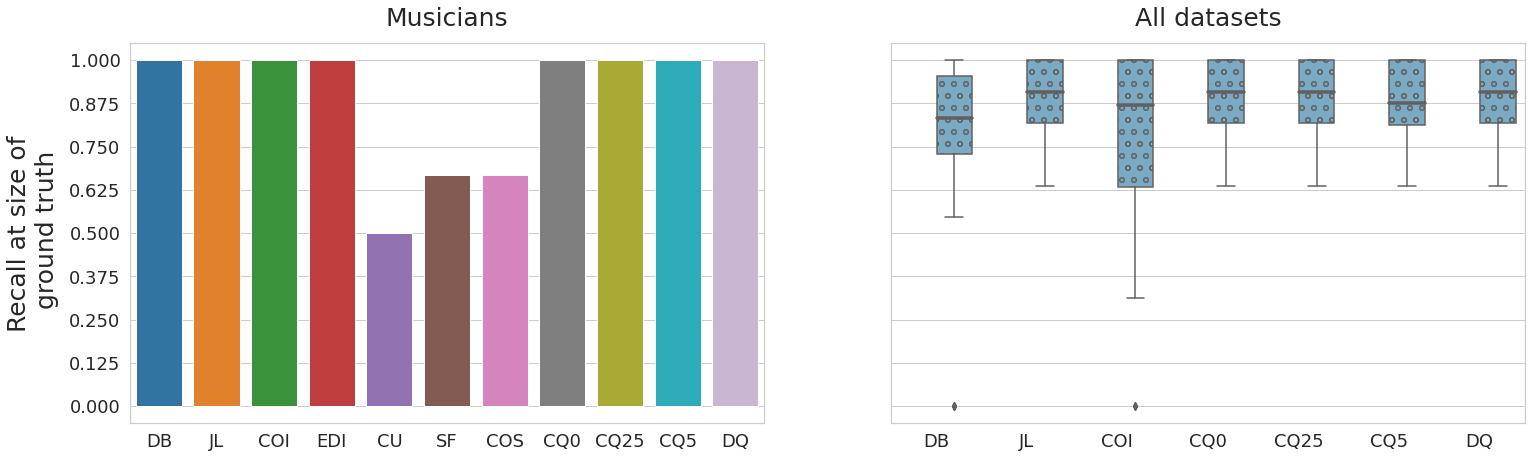

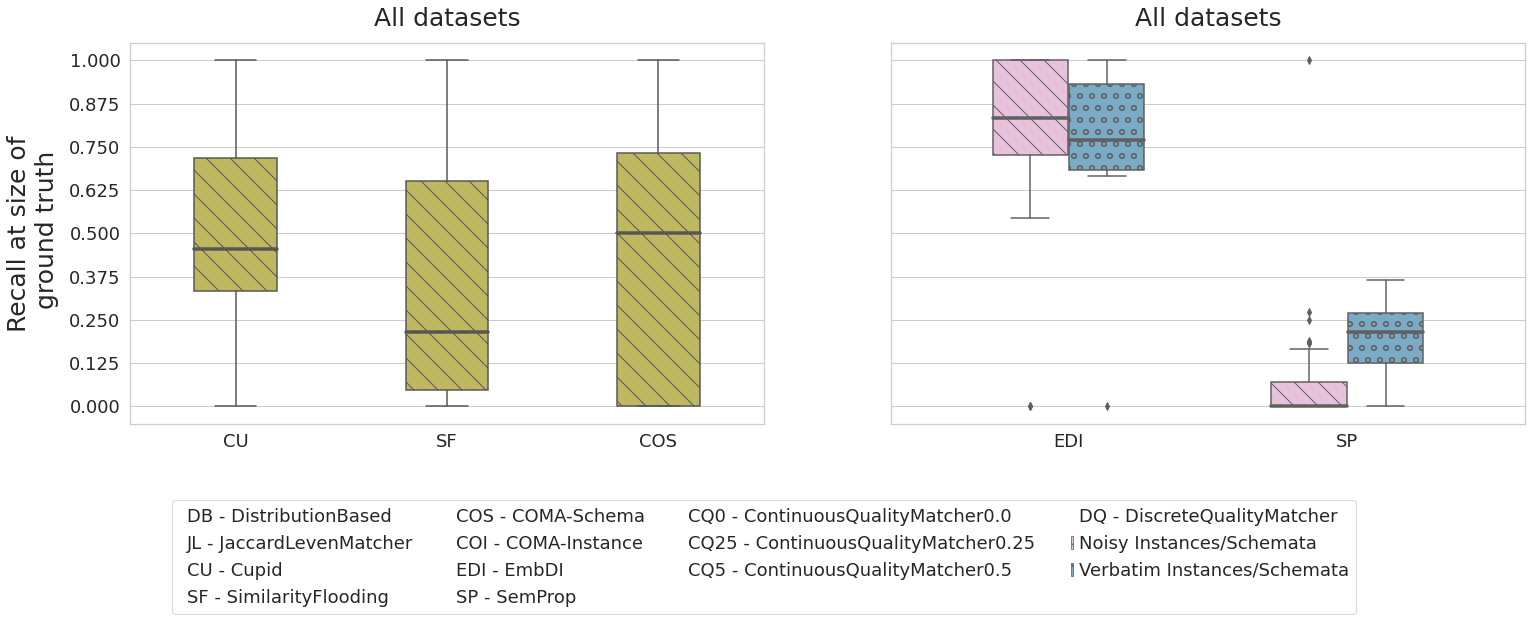

In [24]:
title = "Recall at size of\n ground truth"
df1 = None
for c in config:
    data = split_data_by_type(best_rec_gnd_pd, c)
    data['Problem'] = c['problem']

    if df1 is None:
        df1 = data
    else:
        df1 = pd.concat([df1, data])
        
df = best_rec_gnd_pd.copy()

big_df = dict()
for c in config:
    big_df[c['problem']] = make_data_final_plot(df, instance_order, schema_order, hybrid_order, c)

print_joinable_results(df1, title)

## Precision at 90%

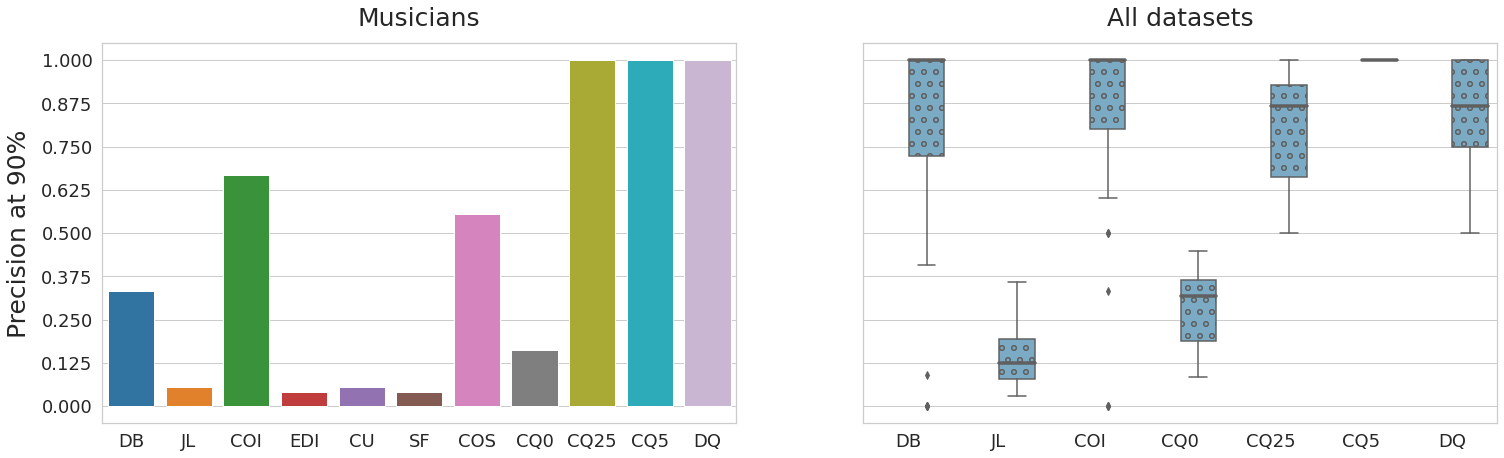

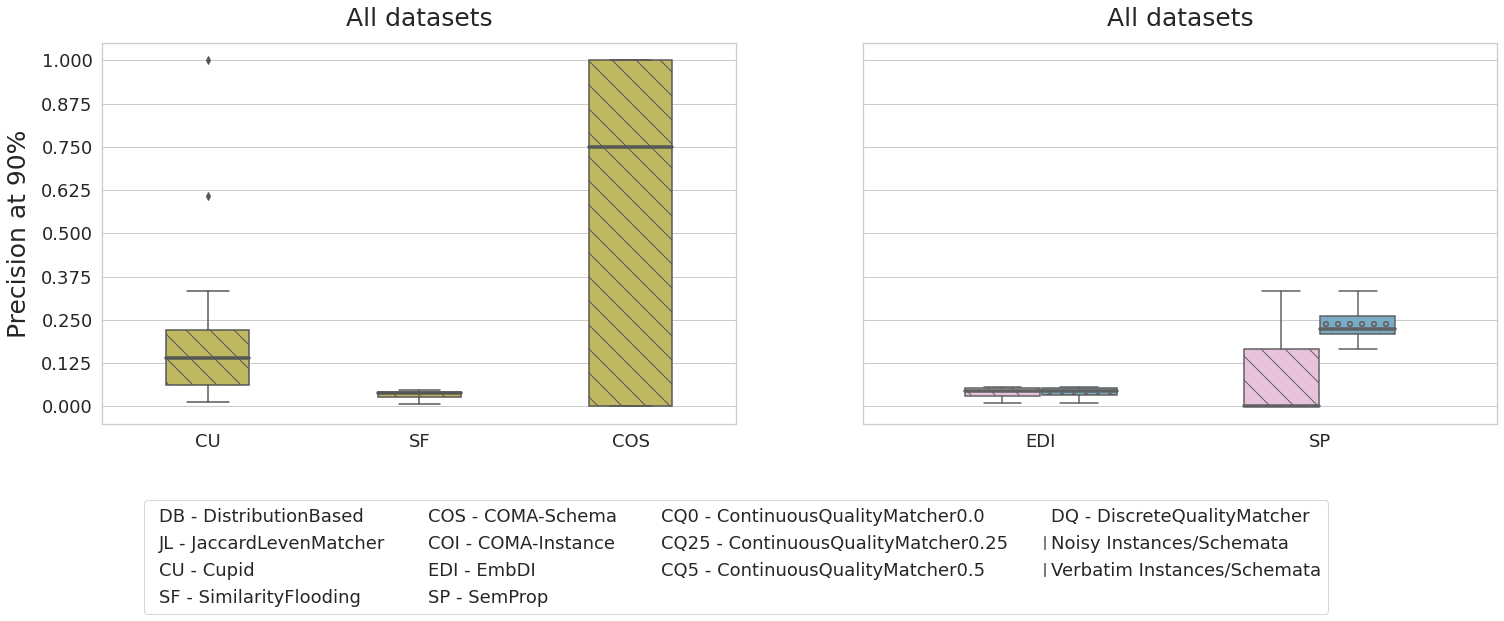

In [25]:
title = "Precision at 90%"
df1 = None
for c in config:
    data = split_data_by_type(best_prec90_pd, c)
    data['Problem'] = c['problem']

    if df1 is None:
        df1 = data
    else:
        df1 = pd.concat([df1, data])
        
df = best_prec90_pd.copy()

big_df = dict()
for c in config:
    big_df[c['problem']] = make_data_final_plot(df, instance_order, schema_order, hybrid_order, c)

print_joinable_results(df1, title)

## Precision at 50%

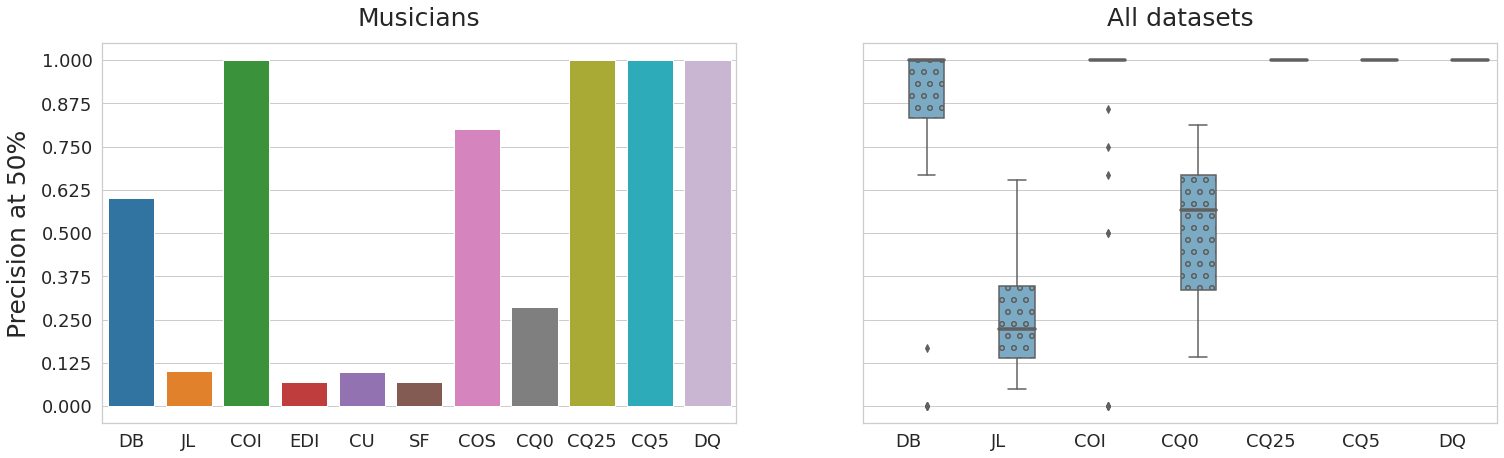

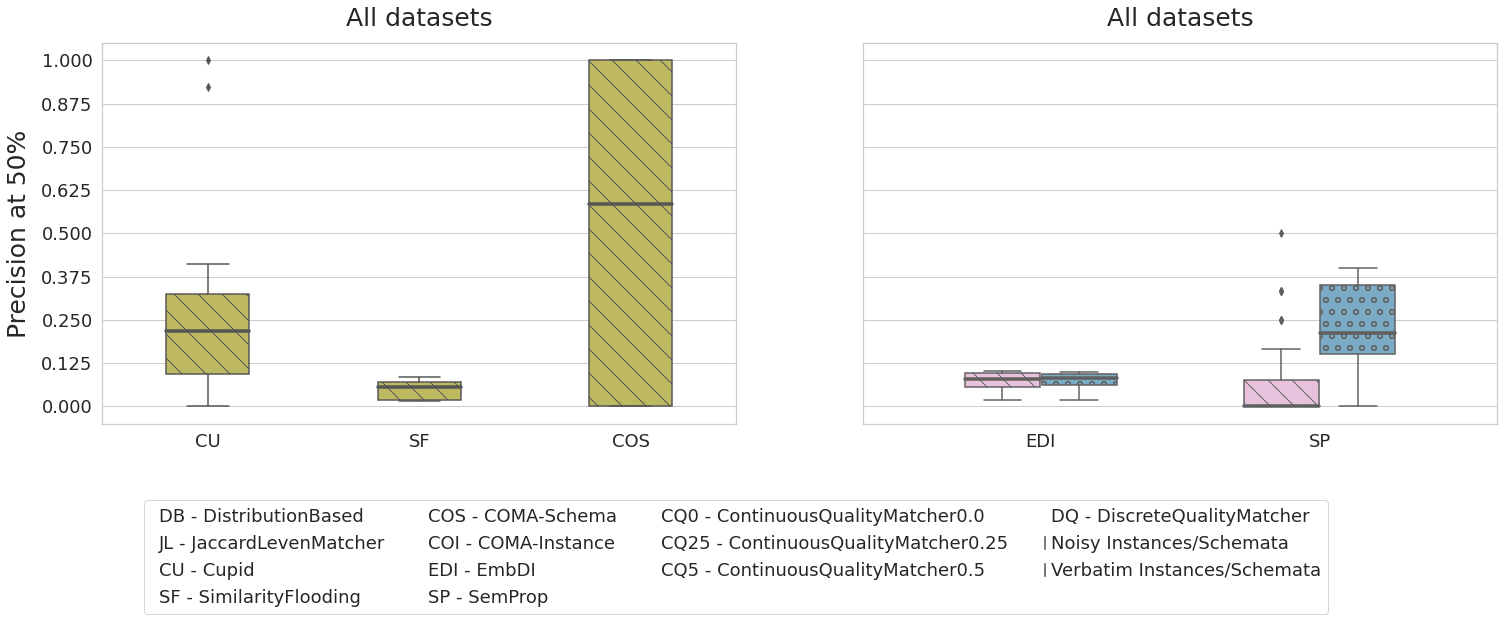

In [26]:
title = "Precision at 50%"
df1 = None
for c in config:
    data = split_data_by_type(best_prec50_pd, c)
    data['Problem'] = c['problem']

    if df1 is None:
        df1 = data
    else:
        df1 = pd.concat([df1, data])
        
df = best_prec50_pd.copy()

big_df = dict()
for c in config:
    big_df[c['problem']] = make_data_final_plot(df, instance_order, schema_order, hybrid_order, c)

print_joinable_results(df1, title)

## Precision at 10%

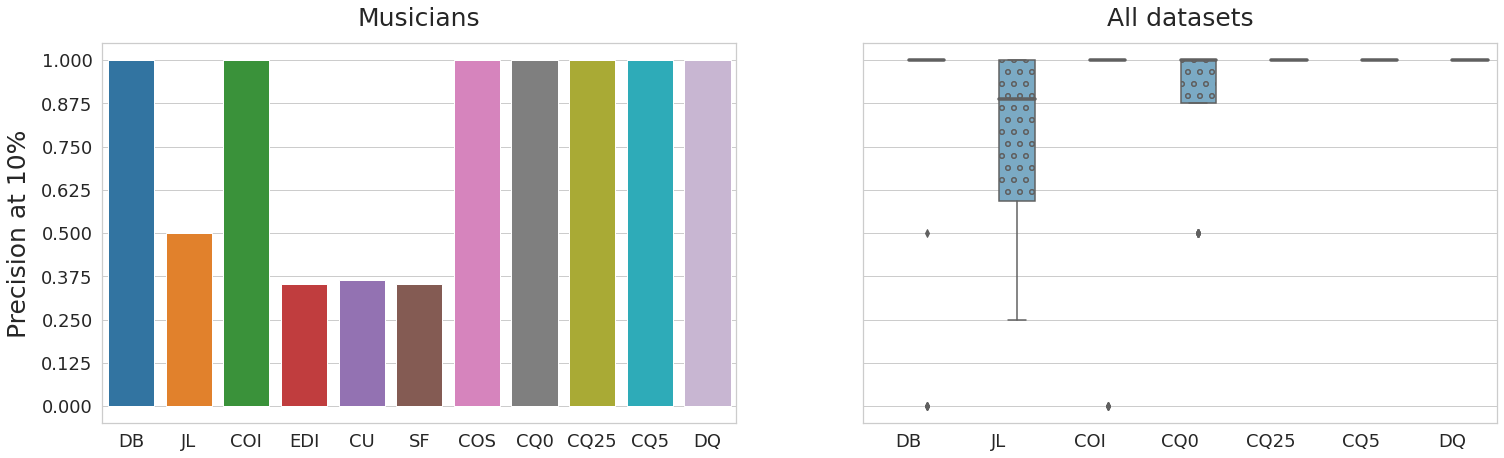

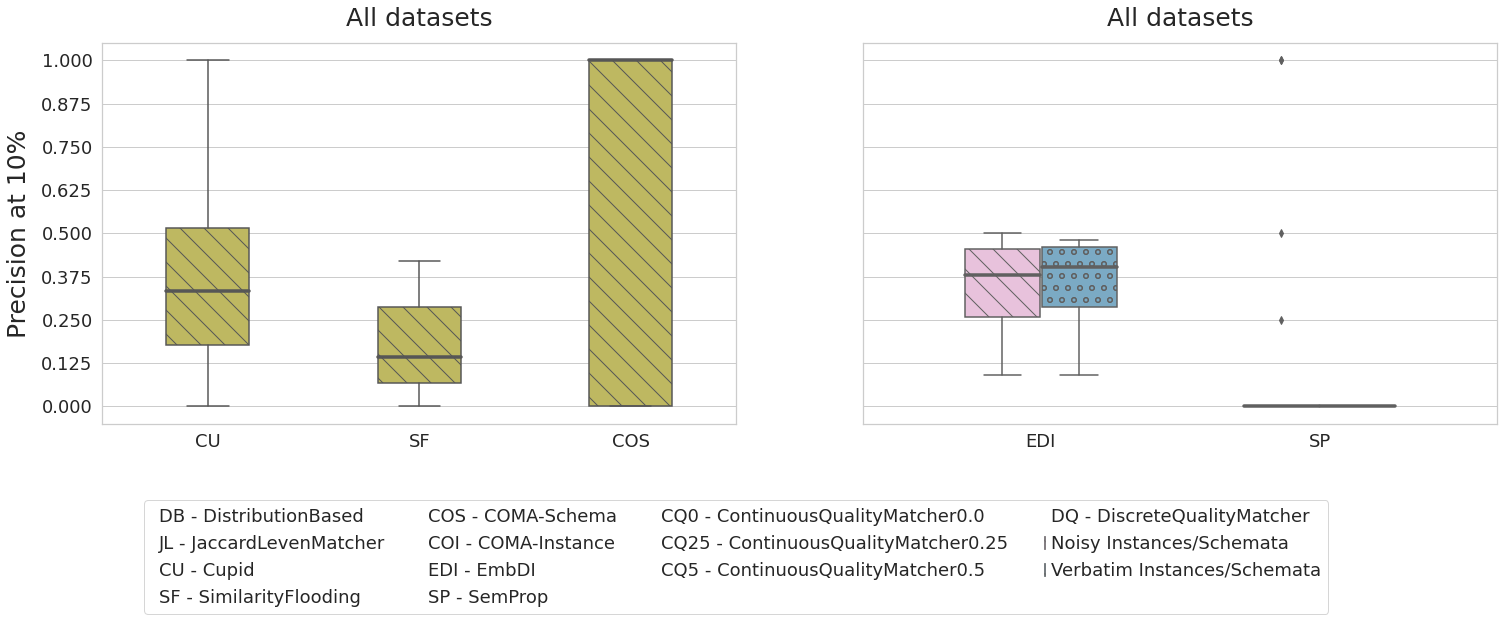

In [27]:
title = "Precision at 10%"
df1 = None
for c in config:
    data = split_data_by_type(best_prec10_pd, c)
    data['Problem'] = c['problem']

    if df1 is None:
        df1 = data
    else:
        df1 = pd.concat([df1, data])
        
df = best_prec10_pd.copy()

big_df = dict()
for c in config:
    big_df[c['problem']] = make_data_final_plot(df, instance_order, schema_order, hybrid_order, c)

print_joinable_results(df1, title)

## Precision

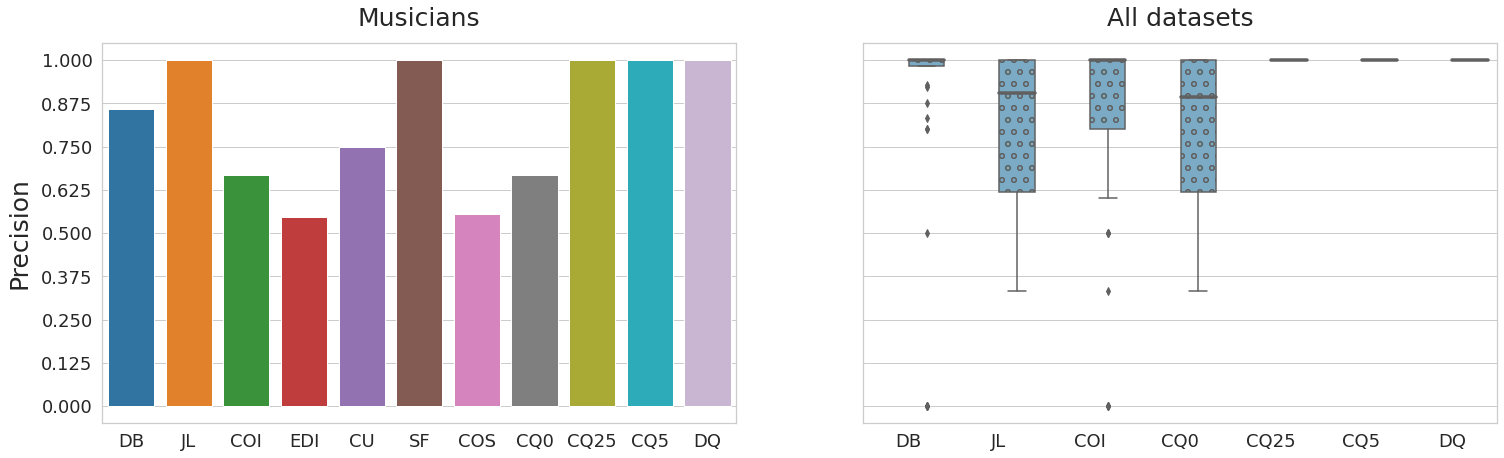

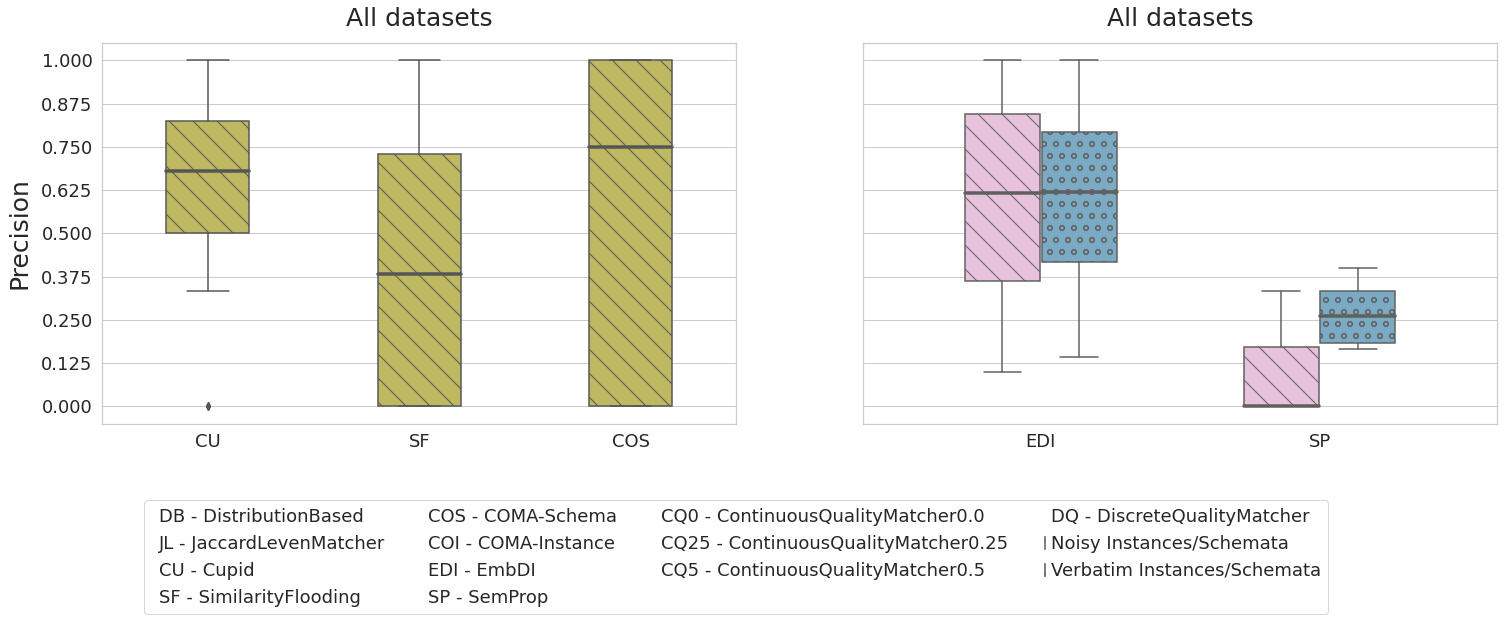

In [28]:
title = "Precision"
df1 = None
for c in config:
    data = split_data_by_type(best_prec_pd, c)
    data['Problem'] = c['problem']

    if df1 is None:
        df1 = data
    else:
        df1 = pd.concat([df1, data])
        
df = best_prec_pd.copy()

big_df = dict()
for c in config:
    big_df[c['problem']] = make_data_final_plot(df, instance_order, schema_order, hybrid_order, c)

print_joinable_results(df1, title)

## F1-Score

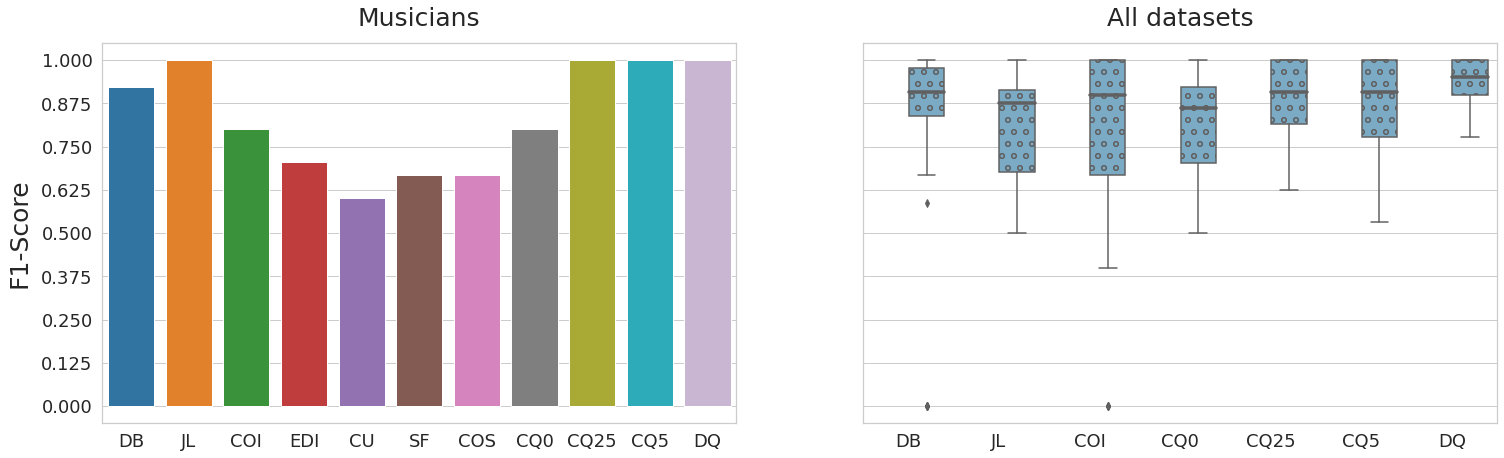

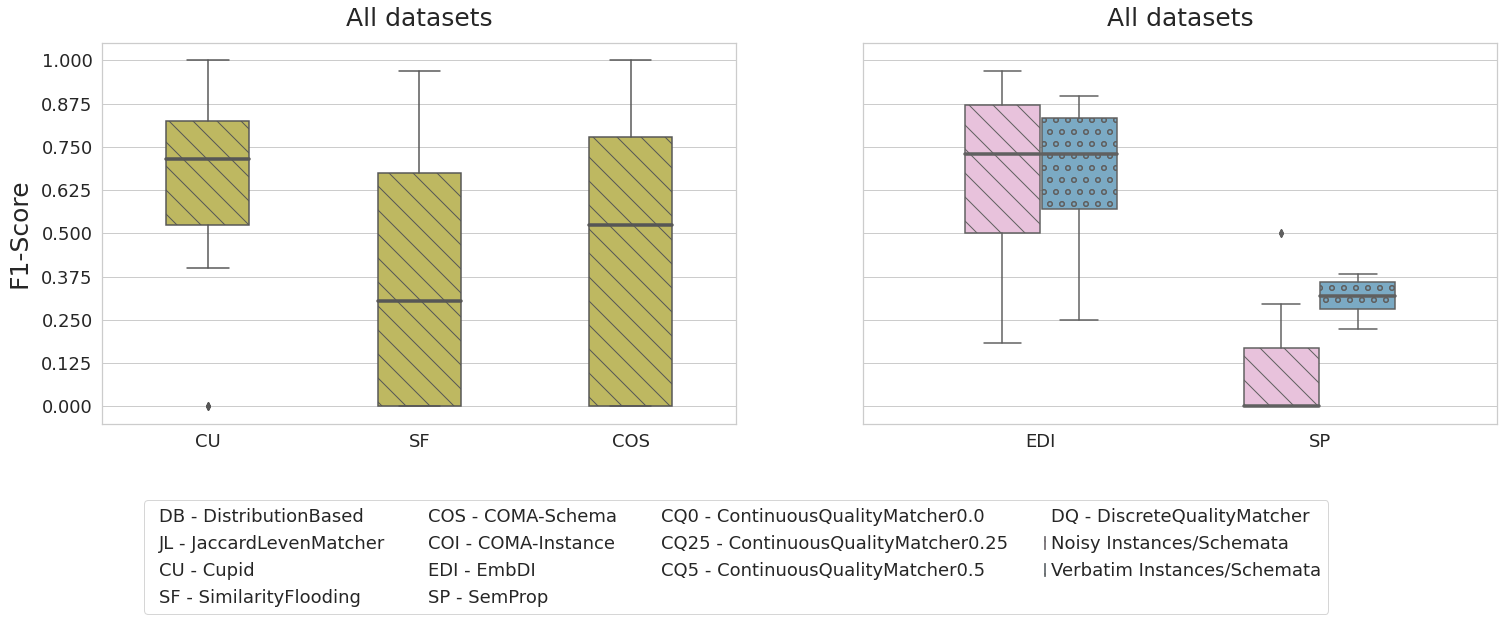

In [29]:
title = "F1-Score"
df1 = None
for c in config:
    data = split_data_by_type(best_f1_pd, c)
    data['Problem'] = c['problem']

    if df1 is None:
        df1 = data
    else:
        df1 = pd.concat([df1, data])
        
df = best_f1_pd.copy()

big_df = dict()
for c in config:
    big_df[c['problem']] = make_data_final_plot(df, instance_order, schema_order, hybrid_order, c)

print_joinable_results(df1, title)